# Libraries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import tensorflow as tf
import argparse
import os

Using TensorFlow backend.


In [2]:
INIT_LR = 1e-4
EPOCHS = 10

# Loading and Preprocessing Dataset

In [24]:
with_mask_path = 'dataset/with_mask'
without_mask_path = 'dataset/without_mask'
dir_mask = os.listdir(with_mask_path)
dir_without_mask = os.listdir(without_mask_path)

In [29]:
indexes = np.random.randint(low=10,high=500,size=10)

In [32]:
def show_images(direc):
    fig = plt.figure(figsize=(15,4))
    if direc == "Masked":
        base = with_mask_path
        direc = dir_mask
    elif direc == "Without Mask":
        base = without_mask_path
        direc = dir_without_mask
    else:
        print("Enter Valid Name")
        return 0
    for i in range(10):
        path = base + '/' + direc[indexes[i]]
        image=imread(path)
        fig.add_subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)

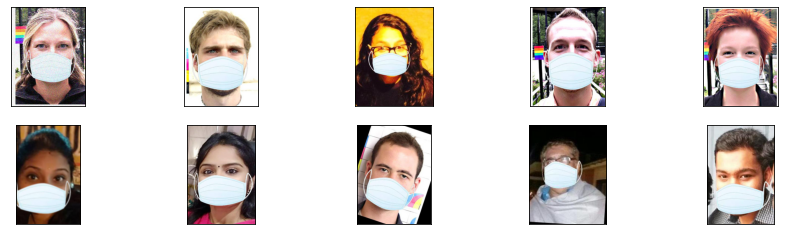

In [33]:
show_images("Masked")

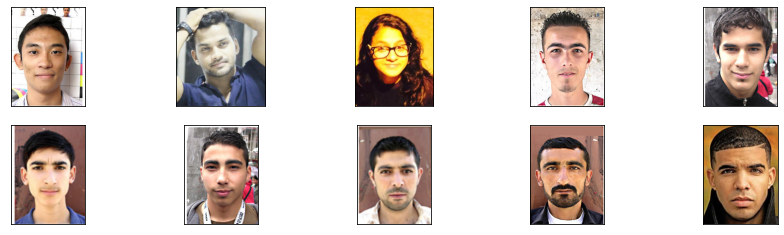

In [34]:
show_images("Without Mask")

# Preprocess Images

In [40]:
os.mkdir("Processed Dataset")
os.mkdir("Processed Dataset/with_ mask")
with_mask_path_processed = "Processed Dataset/with_ mask"
os.mkdir("Processed Dataset/without_ mask")
without_mask_path_processed = "Processed Dataset/without_ mask"

In [41]:
# Processing and Saving With mask images
for i in dir_mask:
    input_imagePath = with_mask_path + '/' + i
    output_imagePath = with_mask_path_processed + '/' + i
    image = load_img(input_imagePath, target_size=(225, 225))
    image = img_to_array(image)
    image = preprocess_input(image)
    save_img(output_imagePath, image)

In [42]:
# Processing and Saving Without mask images
for i in dir_without_mask:
    input_imagePath = without_mask_path + '/' + i
    output_imagePath = without_mask_path_processed + '/' + i
    image = load_img(input_imagePath, target_size=(225, 225))
    image = img_to_array(image)
    image = preprocess_input(image)
    save_img(output_imagePath, image)

# Image Generator

In [44]:
train_datagen =  ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory("Processed Dataset",
                                                    batch_size=25,
                                                    class_mode='binary',
                                                    target_size=(225, 225))

Found 1376 images belonging to 2 classes.


# Fine-Tuning the Xception Model

In [52]:
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(225, 225, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [54]:
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [55]:
history = model.fit(train_generator,epochs = EPOCHS)

  ...
    to  
  ['...']
Train for 56 steps
Epoch 1/10
56/56 [==============================] - 45s 812ms/step - loss: 0.5828 - accuracy: 0.7318
Epoch 2/10
56/56 [==============================] - 45s 808ms/step - loss: 0.3832 - accuracy: 0.9048
Epoch 3/10
56/56 [==============================] - 49s 872ms/step - loss: 0.2837 - accuracy: 0.9360
Epoch 4/10
56/56 [==============================] - 49s 878ms/step - loss: 0.2488 - accuracy: 0.9295
Epoch 5/10
56/56 [==============================] - 48s 866ms/step - loss: 0.2143 - accuracy: 0.9426
Epoch 6/10
56/56 [==============================] - 49s 879ms/step - loss: 0.1999 - accuracy: 0.9426
Epoch 7/10
56/56 [==============================] - 49s 879ms/step - loss: 0.1728 - accuracy: 0.9528
Epoch 8/10
56/56 [==============================] - 49s 882ms/step - loss: 0.1576 - accuracy: 0.9549
Epoch 9/10
56/56 [==============================] - 49s 871ms/step - loss: 0.1540 - accuracy: 0.9520
Epoch 10/10
56/56 [============================

In [56]:
train_acc=history.history['accuracy']
train_loss=history.history['loss']

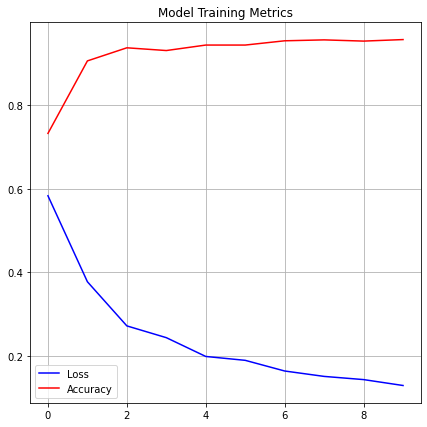

In [57]:
fig=plt.figure(figsize=(7,7))
plt.title('Model Training Metrics')
plt.grid()
plt.plot(train_loss, color='blue', label='Loss')
plt.plot(train_acc, color='red', label='Accuracy')
plt.legend()

In [60]:
model.save("face_mask_NN.h5")

# Real Time Object Detection with OpenCV

In [3]:
model=tf.keras.models.load_model("face_mask_NN.h5")

In [4]:
import cv2

In [5]:
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector","res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [51]:
def mask_detect(image):    
    
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()


    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is  greater than the minimum confidence
        if confidence > 0.4:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))


            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (225, 225))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            
            [predictions] = model.predict(face)[0]
            label = "Mask" if predictions <= 0.4 else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            acc_percentage = predictions if label == "No Mask" else 1-predictions
            text_img = "{} : {:.2f}%".format(label, acc_percentage*100)
            cv2.putText(image, text_img, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

In [46]:
# using a webcam
cam = cv2.VideoCapture(1)
out = cv2.VideoWriter('Face-Mask.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (640,480))
cam.set(3,640)
cam.set(4,480)
cam.set(10,130)

while True:
    success, image = cam.read()
    if success == True:
        mask_detect(image)
        cv2.imshow("Result", image)
        out.write(image)
        if cv2.waitKey(1) & 0xFF == ord('a'):
            break
cam.release()
out.release()
cv2.destroyAllWindows()

# Exmaples

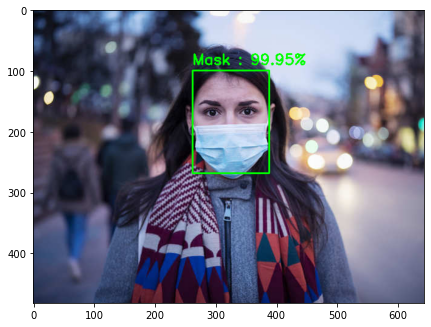

In [53]:
image = '1.jpg'
image = imread(image)
mask_detect(image)
figr=plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

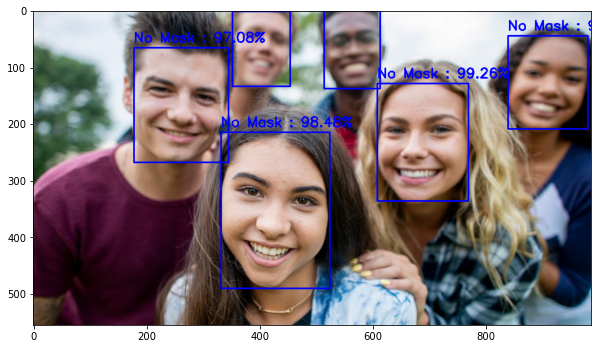

In [54]:
image = '2.jpg'
image = imread(image)
mask_detect(image)
figr=plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

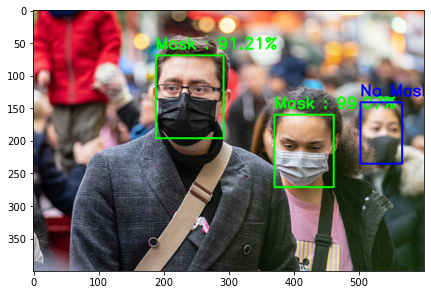

In [55]:
image = '3.jpg'
image = imread(image)
mask_detect(image)
figr=plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

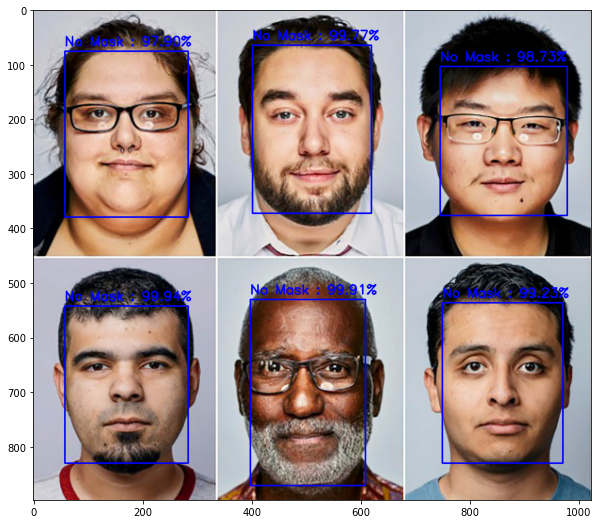

In [56]:
image = '4.jpg'
image = imread(image)
mask_detect(image)
figr=plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

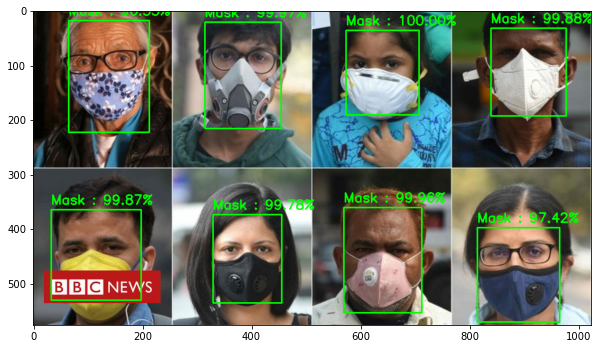

In [57]:
image = '5.jpg'
image = imread(image)
mask_detect(image)
figr=plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()